# Calculate phrasal statistics

Check that our phrases don't differ across conditions in terms of statistical properties, such as bigram frequency in corpora or transition probability.

In [2]:
import numpy as np
import pandas as pd
import re
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import random

dir = 'U:\ownCloud\projects\FakeDiamond\stimuli'

# Phrases

In [12]:
adjectives_subsective = ['actual','authentic','average','bad','current','genuine','good','important',
                         'new','old','perfect','real','special','true','typical','unique']
#                          'standard','rare','classic','permanent','temporary','famous','regular','simple']
adjectives_privative = ['artificial','counterfeit','fabricated','fake','false','fictional','fictitious','former',
                        'hypothetical','imaginary','mock','mythical','past','phony','spurious','virtual'] 
consonant_strings = ['xkq', 'qxsw', 'mtpv', 'rjdnw', 'wvcnz', 'zbxlv','tqvgqrz', 'bxfjwts','mghljkqr',
                     'kmlsdjtw','ptrgsbkv','zrtqgfplh','vpbyzkgrf','htbqzylm','ypdcglkc','fxldmr','rvqf']

In [14]:
# read in our cleaned list of nouns 
nouns = pd.read_csv(os.path.join(dir, 'nouns_cleaned_2023-04-14.csv'))

# shuffle adjectives, then repeat them into a list of 298 adjectives
def create_adjective_list(adjectives, nouns):
    adjectives_repeated = (adjectives * 19)[:len(nouns)]
    adjectives_repeated_shuffled = random.Random(42).sample(adjectives_repeated, len(adjectives_repeated)) # create random.Random instance for reproducibility
    return adjectives_repeated_shuffled

array_adjectives = np.empty((3, len(nouns)), dtype='object') # initialise array
for i, adjectives in enumerate([adjectives_subsective,adjectives_privative,consonant_strings]):
    array_adjectives[i] = create_adjective_list(adjectives, nouns)
    
# transpose and flatten to put into big df later
adjectives_all = np.transpose(array_adjectives).flatten()

phrases = pd.DataFrame(np.repeat(nouns.values, 3, axis=0)) # repeat critical nouns 3 times for 3 denotation conditions
phrases.columns = nouns.columns # assign column names 
phrases['denotation'] = ['subsective','privative','baseline'] * len(nouns) # add denotation condition

phrases['adjective'] = adjectives_all
phrases.rename(columns={'item_nr': 'set_nr', 'word': 'noun'}, inplace=True)
phrases['phrase'] = nouns_x.adjective + ' ' + nouns_x.noun
phrases

,noun,set_nr,concreteness,Zipf,Length,Syllables,Phonemes,AoA,CNC_M,Valence,RT,CNC_SD,IMAG,denotation,adjective,phrase
0,sulphur,1,concrete,3.351834,7,2,5,6,4.23,4.7647,668.25,1.25,4.727,subsective,old,old sulphur
1,sulphur,1,concrete,3.351834,7,2,5,6,4.23,4.7647,668.25,1.25,4.727,privative,imaginary,imaginary sulphur
2,sulphur,1,concrete,3.351834,7,2,5,6,4.23,4.7647,668.25,1.25,4.727,baseline,tqvgqrz,tqvgqrz sulphur
3,longing,1,abstract,3.408385,7,2,5,8,2.14,4.303,679.666667,1.13,3.235,subsective,special,special longing
4,longing,1,abstract,3.408385,7,2,5,8,2.14,4.303,679.666667,1.13,3.235,privative,past,past longing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,syringe,140,concrete,3.122247,7,2,5,10,4.81,3.4375,675.194444,0.57,6.4,privative,fictional,fictional syringe
836,syringe,140,concrete,3.122247,7,2,5,10,4.81,3.4375,675.194444,0.57,6.4,baseline,zbxlv,zbxlv syringe
837,wrath,140,abstract,3.409226,5,1,3,12,2.42,2.6364,627.324324,1.33,2.875,subsective,real,real wrath
838,wrath,140,abstract,3.409226,5,1,3,12,2.42,2.6364,627.324324,1.33,2.875,privative,mythical,mythical wrath


## Calculate phrase frequency

Calculate two types of bigram frequencies in the past 100 years (1919-2019) in British English
- average bigram frequency
- average frequency of dependency between target adjective and noun--adjective modifying the noun conceptually, not just in bigrams (e.g., tasty frozen pizza, tasty pizza)

In [21]:
# parameters for Google Books Ngram
corpus = 'eng-GB-2019' # British English
startYear, endYear = 1919, 2019 # most recent 100 years available on Google Books Ngram
smoothing = 3 # for extrapolating in case there's missing; this is default setting 
caseInsensitive = True 

print(f'Calculating bigram frequency...')
frequencies_dep = [] # dependency frequency
frequencies_seq = [] # sequence frequency
frequencies_all = [frequencies_dep, frequencies_seq] # for looping
for index, row in phrases.iterrows():
    query_w2w1 = row.noun + '_NOUN' + '=>' + row.adjective + '_ADJ' # dependency frequency
    query_w1w2 = row.adjective + '_ADJ' + ' ' + row.noun + '_NOUN' # sequence frequency
    queries = [query_w2w1, query_w1w2] # for looping

    for query, frequencies in zip(queries, frequencies_all):
        params = dict(content=query, year_start=startYear, year_end=endYear,
                      corpus=corpus, smoothing=smoothing,
                      case_insensitive=caseInsensitive)
        req = requests.get('http://books.google.com/ngrams/graph', params=params)
        res = re.findall('"timeseries": \[(.*?)\]}', req.text) # find timeseries associated with each query
        if res: 
            timeseries = list(map(float, res[0].split(','))) 
            average_frequency = sum(timeseries) / len(timeseries) # calculate mean frequency across time
            frequencies.append(average_frequency)
        else: 
            frequencies.append(0)
    print(str(index+1) + ' out of ' + str(len(phrases)) + ' done.')
phrases['frequency_dep'] = frequencies_dep
phrases['frequency_seq'] = frequencies_seq
phrases.to_csv(os.path.join(f'phrases_bigramFreq_{date.today()}.csv'), index=False)
print()

Calculating bigram frequency...
1 out of 840 done.
2 out of 840 done.
3 out of 840 done.
4 out of 840 done.
5 out of 840 done.
6 out of 840 done.
7 out of 840 done.
8 out of 840 done.
9 out of 840 done.
10 out of 840 done.
11 out of 840 done.
12 out of 840 done.
13 out of 840 done.
14 out of 840 done.
15 out of 840 done.
16 out of 840 done.
17 out of 840 done.
18 out of 840 done.
19 out of 840 done.
20 out of 840 done.
21 out of 840 done.
22 out of 840 done.
23 out of 840 done.
24 out of 840 done.
25 out of 840 done.
26 out of 840 done.
27 out of 840 done.
28 out of 840 done.
29 out of 840 done.
30 out of 840 done.
31 out of 840 done.
32 out of 840 done.
33 out of 840 done.
34 out of 840 done.
35 out of 840 done.
36 out of 840 done.
37 out of 840 done.
38 out of 840 done.
39 out of 840 done.
40 out of 840 done.
41 out of 840 done.
42 out of 840 done.
43 out of 840 done.
44 out of 840 done.
45 out of 840 done.
46 out of 840 done.
47 out of 840 done.
48 out of 840 done.
49 out of 840 don

395 out of 840 done.
396 out of 840 done.
397 out of 840 done.
398 out of 840 done.
399 out of 840 done.
400 out of 840 done.
401 out of 840 done.
402 out of 840 done.
403 out of 840 done.
404 out of 840 done.
405 out of 840 done.
406 out of 840 done.
407 out of 840 done.
408 out of 840 done.
409 out of 840 done.
410 out of 840 done.
411 out of 840 done.
412 out of 840 done.
413 out of 840 done.
414 out of 840 done.
415 out of 840 done.
416 out of 840 done.
417 out of 840 done.
418 out of 840 done.
419 out of 840 done.
420 out of 840 done.
421 out of 840 done.
422 out of 840 done.
423 out of 840 done.
424 out of 840 done.
425 out of 840 done.
426 out of 840 done.
427 out of 840 done.
428 out of 840 done.
429 out of 840 done.
430 out of 840 done.
431 out of 840 done.
432 out of 840 done.
433 out of 840 done.
434 out of 840 done.
435 out of 840 done.
436 out of 840 done.
437 out of 840 done.
438 out of 840 done.
439 out of 840 done.
440 out of 840 done.
441 out of 840 done.
442 out of 84

786 out of 840 done.
787 out of 840 done.
788 out of 840 done.
789 out of 840 done.
790 out of 840 done.
791 out of 840 done.
792 out of 840 done.
793 out of 840 done.
794 out of 840 done.
795 out of 840 done.
796 out of 840 done.
797 out of 840 done.
798 out of 840 done.
799 out of 840 done.
800 out of 840 done.
801 out of 840 done.
802 out of 840 done.
803 out of 840 done.
804 out of 840 done.
805 out of 840 done.
806 out of 840 done.
807 out of 840 done.
808 out of 840 done.
809 out of 840 done.
810 out of 840 done.
811 out of 840 done.
812 out of 840 done.
813 out of 840 done.
814 out of 840 done.
815 out of 840 done.
816 out of 840 done.
817 out of 840 done.
818 out of 840 done.
819 out of 840 done.
820 out of 840 done.
821 out of 840 done.
822 out of 840 done.
823 out of 840 done.
824 out of 840 done.
825 out of 840 done.
826 out of 840 done.
827 out of 840 done.
828 out of 840 done.
829 out of 840 done.
830 out of 840 done.
831 out of 840 done.
832 out of 840 done.
833 out of 84

## Visualise bigram frequency distribution

In [22]:
# # put back the phrase blocks into one big df
# blocks = []
# for i in range(len(phrases_blocks)):
#     blocks.append(pd.read_csv(os.path.join(f'phrases_block{i+1}_2023-03-01.csv')))
# phrases = pd.concat(blocks)
# phrases.reset_index(inplace=True, drop=True)

# calculate log frequencies 
phrases['frequency_dep_log'] = np.log10(phrases['frequency_dep'])
phrases['frequency_seq_log'] = np.log10(phrases['frequency_seq'])

# # define sethood as phrases sharing a noun
# phrases['set'] = np.repeat(list(map(lambda x:x+1, list(range(int(len(nouns)))))), 32)  # add set number for future use
# col = phrases.pop('set') 
# phrases.insert(0, col.name, col) # move set to the front of df

phrases

C:\Users\rl05\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\rl05\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,noun,set_nr,concreteness,Zipf,Length,Syllables,Phonemes,AoA,CNC_M,Valence,RT,CNC_SD,IMAG,denotation,adjective,phrase,frequency_dep,frequency_seq,frequency_dep_log,frequency_seq_log
0,sulphur,1,concrete,3.351834,7,2,5,6,4.23,4.7647,668.25,1.25,4.727,subsective,old,old sulphur,5.791099e-10,1.709172e-09,-9.237239,-8.767214
1,sulphur,1,concrete,3.351834,7,2,5,6,4.23,4.7647,668.25,1.25,4.727,privative,imaginary,imaginary sulphur,0.000000e+00,0.000000e+00,-inf,-inf
2,sulphur,1,concrete,3.351834,7,2,5,6,4.23,4.7647,668.25,1.25,4.727,baseline,tqvgqrz,tqvgqrz sulphur,0.000000e+00,0.000000e+00,-inf,-inf
3,longing,1,abstract,3.408385,7,2,5,8,2.14,4.303,679.666667,1.13,3.235,subsective,special,special longing,6.415080e-10,5.920740e-10,-9.192798,-9.227624
4,longing,1,abstract,3.408385,7,2,5,8,2.14,4.303,679.666667,1.13,3.235,privative,past,past longing,2.164082e-10,1.657856e-10,-9.664726,-9.780453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,syringe,140,concrete,3.122247,7,2,5,10,4.81,3.4375,675.194444,0.57,6.4,privative,fictional,fictional syringe,0.000000e+00,0.000000e+00,-inf,-inf
836,syringe,140,concrete,3.122247,7,2,5,10,4.81,3.4375,675.194444,0.57,6.4,baseline,zbxlv,zbxlv syringe,0.000000e+00,0.000000e+00,-inf,-inf
837,wrath,140,abstract,3.409226,5,1,3,12,2.42,2.6364,627.324324,1.33,2.875,subsective,real,real wrath,0.000000e+00,0.000000e+00,-inf,-inf
838,wrath,140,abstract,3.409226,5,1,3,12,2.42,2.6364,627.324324,1.33,2.875,privative,mythical,mythical wrath,0.000000e+00,0.000000e+00,-inf,-inf


Find the best phrase in each set of phrases. That is, the phrase with the highest bigram frequency.

In [34]:
# phrases_best_indices = []
# for i in range(1, len(nouns)+1):    
#     # find phrase with highest frequency in each denotation
#     for j in ['subsective','privative']:
#         phrase_set = phrases.query(f'(set=={i}) and (denotation=="{j}")')
#         phrase_best = phrase_set[phrase_set.frequency_dep == phrase_set.frequency_dep.max()] 
#         phrases_best_indices.append(phrase_best.index[0])
# phrases.iloc[phrases_best_indices]

In [35]:
# best_phrases.query('frequency_dep > 0').phrase.tolist()

In [ ]:
best_phrases = phrases.iloc[phrases_best_indices]
print(best_phrases.query('frequency_dep > 0').groupby(['concreteness','denotation']).size())

# f, ax = plt.subplots(1, 2, figsize=(15,3))
# sns.histplot(x='frequency_dep_log', hue='denotation', data=best_phrases.query('frequency_dep == 0'), ax=ax[0], element='step').set(title='Log-transformed bigram frequency based on dependency')

The log frequency distributions of both phrase types (subsective and non-subsective) after removing zero frequencies:

[Text(0.5, 1.0, 'Log-transformed bigram frequency based on sequence')]

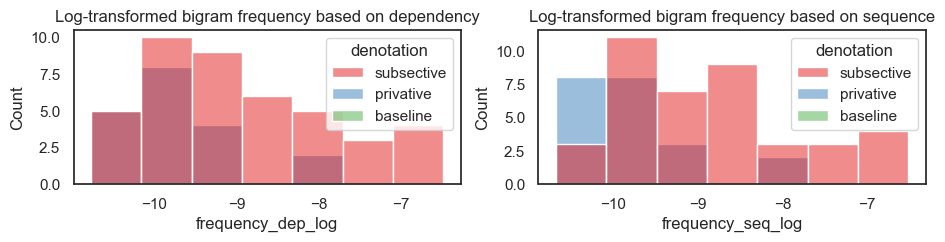

In [40]:
fig, axes = plt.subplots(1,2, figsize=(11,2))
sns.set_context(font_scale=2)
sns.set_theme(style='white', palette='Set1')
sns.histplot(x='frequency_dep_log', hue='denotation', data=phrases, ax=axes[0], element='bars').set(title='Log-transformed bigram frequency based on dependency')
sns.histplot(x='frequency_seq_log', hue='denotation', data=phrases, ax=axes[1], element='bars').set(title='Log-transformed bigram frequency based on sequence')

[Text(0.5, 1.0, 'bigram frequency based on sequence')]

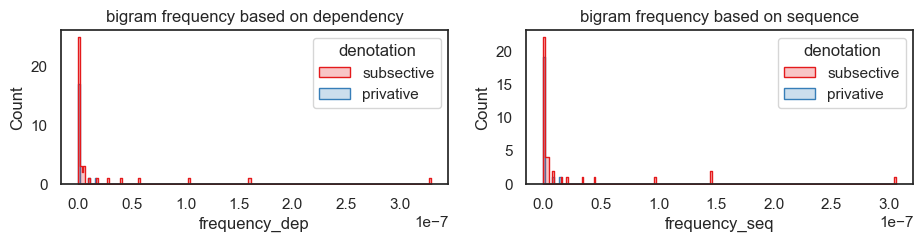

In [33]:
f, ax = plt.subplots(1, 2, figsize=(11,2))
sns.set_context(font_scale=2)
sns.set_theme(style='white', palette='Set1')
sns.histplot(x='frequency_dep', hue='denotation', data=phrases.query('frequency_dep > 0'), ax=ax[0], element='step').set(title='bigram frequency based on dependency')
sns.histplot(x='frequency_seq', hue='denotation', data=phrases.query('frequency_seq > 0'), ax=ax[1], element='step').set(title='bigram frequency based on sequence')

Number of phrases by concreteness conditions after removing zero frequencies

In [174]:
phrases.query('frequency_dep > 0 & frequency_seq > 0')['noun'].nunique()

112

Looking at how the removal of zero bigram frequencies impact our psycholinguistic property matching:

In [166]:
nouns_long

,word,item_nr,condition,Zipf,PoS,Length,AoA,CNC_M,CNC_SD
0,costume,4,concrete,4.171842,noun,7,4.17,4.57,0.86
1,crystal,9,concrete,4.162752,noun,7,7.78,4.58,0.81
2,pedal,11,concrete,3.634756,noun,5,6.50,4.44,0.97
3,rook,13,concrete,2.888860,noun,4,11.59,4.38,1.10
4,mink,14,concrete,3.128705,noun,4,10.32,4.58,0.99
...,...,...,...,...,...,...,...,...,...
839,anarchy,2548,abstract,3.155128,noun,7,13.94,2.12,1.31
840,jilt,2568,abstract,1.598826,noun,4,12.28,2.00,1.15
841,decorum,2572,abstract,2.767618,noun,7,15.12,2.36,1.50
842,way,2582,abstract,6.118429,noun,3,5.39,2.34,1.37


In [196]:
phrases_nonzero = phrases.query('frequency_dep > 0 & frequency_seq > 0').reset_index()

# read in cleaned noun list to get psycholinguistic properties
nouns_long = pd.read_csv(os.path.join(dir, 'nouns_cleaned_2023-03-01.csv'), index_col=False)
nouns_long.set_index('word', inplace=True)

phrases_nonzero['noun_zipf'] = ''
phrases_nonzero['noun_aoa'] = ''
phrases_nonzero['noun_length'] = ''
phrases_nonzero['noun_cnc'] = ''
phrases_nonzero.set_index('noun', inplace=True)
phrases_nonzero['noun_zipf'] = phrases_nonzero.index.map(nouns_long['Zipf'])
phrases_nonzero['noun_aoa'] = phrases_nonzero.index.map(nouns_long['AoA'])
phrases_nonzero['noun_length'] = phrases_nonzero.index.map(nouns_long['Length'])
phrases_nonzero['noun_cnc'] = phrases_nonzero.index.map(nouns_long['CNC_M'])

phrases_nonzero.reset_index(inplace=True)
phrases_nonzero

,noun,index,concreteness,adjective,denotation,phrase,frequency_dep,frequency_seq,frequency_dep_log,frequency_seq_log,noun_zipf,noun_aoa,noun_length,noun_cnc
0,costume,0,concrete,actual,subsective,actual costume,1.196396e-09,1.114929e-09,-8.922125,-8.952753,4.171842,4.17,7,4.57
1,costume,1,concrete,authentic,subsective,authentic costume,3.224809e-09,1.961011e-09,-8.491496,-8.707520,4.171842,4.17,7,4.57
2,costume,2,concrete,average,subsective,average costume,1.823691e-10,1.800532e-10,-9.739049,-9.744599,4.171842,4.17,7,4.57
3,costume,3,concrete,bad,subsective,bad costume,2.735950e-10,2.411877e-10,-9.562892,-9.617645,4.171842,4.17,7,4.57
4,costume,4,concrete,current,subsective,current costume,3.180741e-10,2.764691e-10,-9.497472,-9.558353,4.171842,4.17,7,4.57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,rehash,26822,abstract,good,subsective,good rehash,5.973443e-11,2.507194e-11,-10.223775,-10.600812,1.974489,12.24,6,2.17
1520,rehash,26824,abstract,new,subsective,new rehash,6.649890e-11,3.511690e-11,-10.177186,-10.454484,1.974489,12.24,6,2.17
1521,rehash,26825,abstract,old,subsective,old rehash,2.290375e-10,1.674349e-10,-9.640093,-9.776154,1.974489,12.24,6,2.17
1522,rehash,26847,abstract,virtual,privative,virtual rehash,2.312194e-11,1.991051e-11,-10.635976,-10.700918,1.974489,12.24,6,2.17


[Text(0.5, 1.0, 'Word length')]

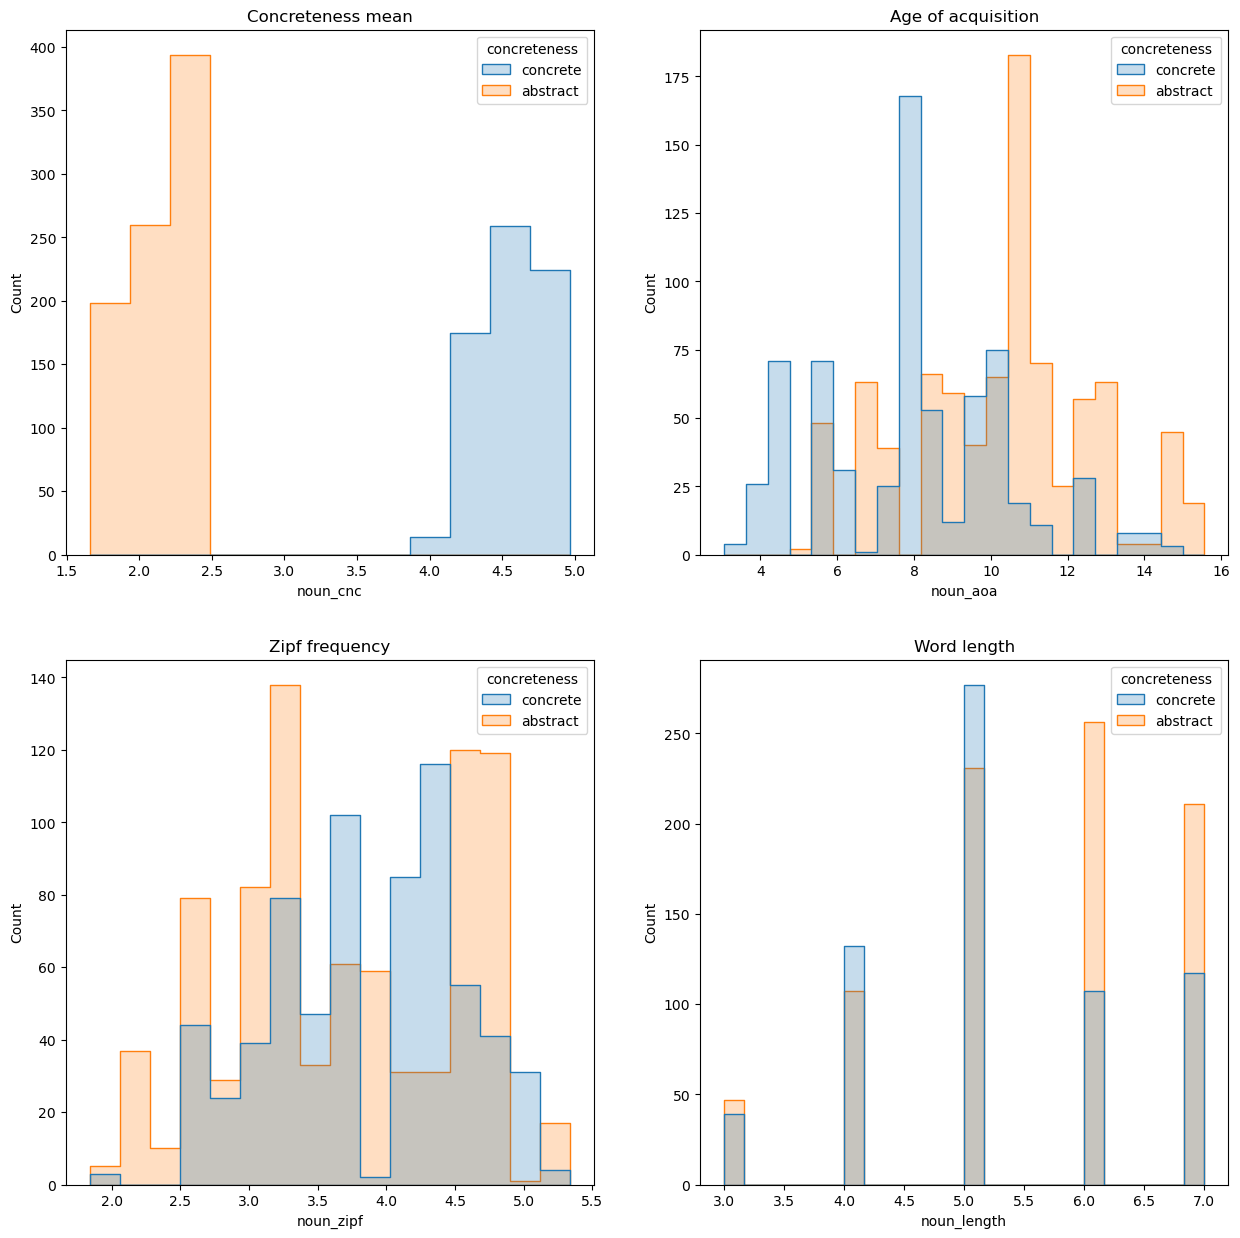

In [198]:
f, ax = plt.subplots(2, 2, figsize=(15,15))
sns.set_context(font_scale=2)
sns.histplot(x='noun_cnc', hue='concreteness', data=phrases_nonzero, ax=ax[0,0], element='step').set(title='Concreteness mean')
# sns.scatterplot(x='Conc_M', y='Conc_SD', data=ratings_all, s=2, alpha=0.5, ax=ax[0,1], color='black').set(title='Concreteness mean-SD distribution')
# sns.scatterplot(x='noun_cnc', y='CNC_SD', data=phrases_nonzero.query('condition == "abstract"'), s=5, alpha=0.7, ax=ax[0,1], color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
# )
# sns.scatterplot(x='noun_cnc', y='CNC_SD', data=phrases_nonzero.query('condition == "concrete"'), s=5, alpha=1, ax=ax[0,1], color=(1.0, 0.4980392156862745, 0.054901960784313725)
# )
sns.histplot(x='noun_aoa', hue='concreteness', data=phrases_nonzero, ax=ax[0,1], element='step').set(title='Age of acquisition')
sns.histplot(x='noun_zipf', hue='concreteness', data=phrases_nonzero, ax=ax[1,0], element='step').set(title='Zipf frequency')
sns.histplot(x='noun_length', hue='concreteness', data=phrases_nonzero, ax=ax[1,1], element='step').set(title='Word length')
# f.suptitle('Psycholinguistic properties of {} concrete-abstract word pairs'.format(int(len(nouns_long)/2)), fontsize=16)

## Calculate transition probability

In [18]:
from nltk.corpus.reader.bnc import BNCCorpusReader
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [3]:
bnc_reader = BNCCorpusReader(root='U:\BNC\download\Texts', fileids=r'[A-K]/\w*/\w*\.xml')

In [15]:
from nltk.corpus import brown
finder = BigramCollocationFinder.from_words(brown.words())
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [16]:
finder.apply_freq_filter(3)

In [22]:
creature_filter = lambda *w: 'diamond' not in w
finder.apply_ngram_filter(creature_filter)
# return the 10 n-grams with the highest PMI
bigram_measures = nltk.collocations.BigramAssocMeasures()
print (finder.nbest(bigram_measures.likelihood_ratio, 10))

[]


In [311]:
bnc_reader = BNCCorpusReader(root='U:\BNC\download\Texts', fileids=r'[A-K]/\w*/\w*\.xml')
finder_backup = BigramCollocationFinder.from_words(bnc_reader.words(fileids=None))

In [301]:
finder = finder_backup

# Ngrams with target as a member
creature_filter = lambda *w: 'diamond' not in w

## Bigrams
finder = BigramCollocationFinder.from_words(bnc_reader.words(fileids=None))
# only bigrams that appear 3+ times
finder.apply_freq_filter(3)
# only bigrams that contain 'creature'
finder.apply_ngram_filter(creature_filter)
# return the 10 n-grams with the highest PMI
print (finder.nbest(bigram_measures.likelihood_ratio, 10))

[('diamond', 'ring'), ('a', 'diamond'), ('diamond', 'sapphire'), ('diamond', 'jubilee'), ('diamond', 'cluster'), ('little', 'diamond'), ('rough', 'diamond'), ('diamond', 'solitaire'), ('µm', 'diamond'), ('diamond', 'rings')]


In [333]:
finder

In [337]:
finder = finder_backup
creature_filter = lambda *w: 'diamond' not in w
finder_backup.apply_ngram_filter(creature_filter)
print (finder.nbest(bigram_measures.likelihood_ratio, 10))

[]
